# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.
* 파이썬의 머신러닝 라이브러리인 Scikit-learn을 사용합니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.22.0
1.14.6


# 데이터 로드하기
*  데이터 출처 : https://github.com/akngs/petitions

In [0]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 합니다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
url ='https://drive.google.com/open?id=1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4'
id = url.split('=')[1]
print(id)

1d8VEAj6n83wT1YRlCrhoU_1mMSvYpXc4


In [0]:
# 내 구글 드라이브에 해당 csv파일을 다운로드
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('petition.csv')  

In [5]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어온다.
petitions = pd.read_csv('petition.csv',
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 본다.
petitions.shape

(377756, 8)

In [6]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [7]:
# 전체 데이터 중 투표가 500건 이상인 데이터를 기준으로 가져옵니다. 
# 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거합니다.
petition_remove_outlier = petitions.loc[(petitions['votes'] > 500) & 
                                        (petitions['votes'] < 200000)]
petition_remove_outlier.shape

(5109, 8)

In [0]:
df = petition_remove_outlier.copy()

In [9]:
df.describe()

,article_id,answered,votes
count,5109.000000,5109.0,5109.000000
mean,252208.264044,0.0,5674.709141
std,137485.014370,0.0,14334.261910
min,28.000000,0.0,501.000000
25%,145294.000000,0.0,771.000000
50%,242471.000000,0.0,1456.000000
75%,374255.000000,0.0,3794.000000
max,491954.000000,0.0,197343.000000


# 이진분류 대상 정하기
* 답변 여부에 대해 분류해보는 실습을 해볼까 했지만 표준편차가 너무 크고 모수가 적어 분류 데이터로 적합하지 않습니다.

In [10]:
# 답변대상건이 몇 건인지 봅니다. 
df.loc[df['answered'] == 1].shape

(0, 8)

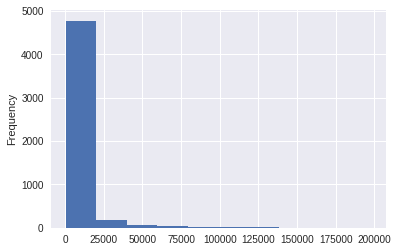

In [11]:
%matplotlib inline 
df['votes'].plot.hist()

# 투표수를 평균보다 높게 혹은 적게 받는지 예측해 보기

In [0]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

In [13]:
# 평균 투표수를 구해 옵니다.
votes_mean = df['votes'].mean()
votes_mean

5674.709140732041

In [0]:
# 투표수가 평균을 넘으면 1로 다시 세팅합니다.
df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [15]:
df['votes_pos_neg'].dtypes

dtype('bool')

In [0]:
# 타입을 boolean 에서 int로 변경해 줍니다.
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

In [18]:
df[['votes', 'votes_pos_neg']].head()

,votes,votes_pos_neg
7,2137,0
13,679,0
21,11293,1
24,1933,0
28,1251,0


In [0]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 13

In [20]:
sample_title = df.loc[sample_index, 'title']
sample_title

'『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 문제점 개선 청원'

In [21]:
sample_content = petitions.loc[sample_index, 'content']
sample_content

'(현황)\\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다. 우리들 대부분의 아버님들 중 12만위는 전쟁 후 지금껏 유해도 수습 못했고 忌日도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다.\\n전후 원호제도는 빈약하여 전사자와 그 가족에 대한 보상과 연금 등은 너무 빈약했고,  그 후도 경제발전 수준을 따라가지도 못하였는데, 1960년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 2001년7월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 위해 1997년 12월31일을 기준으로 아래의 제적유자녀 1)와 승계유자녀 2)에게는 先順位자녀 1人에 대하여만「6ㆍ25전몰 군경자녀수당」을 지급하게 되었으나, 단서조항으로 1998년1월1일 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여, 어머니 돌아가신 날 하루 차이로 “미수당유자녀” 아래표 3)라는 보훈정책의 사각지대가 생겨났던 것입니다.\\n신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니\\n6.25전쟁에서 똑 같이 아버지가 전사한 군·경유자녀들인데, 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 있는 『국가유공자 등 예우 및 지원에 관한 법률』제16조3(6.25자녀수당)의1,(단서조항 : 1998년 1월 1일을 삭제하는 법안)을 19대 국회에서 더민주당 민홍철 의원님(경남 김해)이 2014년 2월 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 2015년 11월30일 제337회 정기회에서 재석 의원 만장일치로 법이 통과되어 12월29일 법률 제13697호로 공포된바 있었습니다.\\n그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 

# 전처리 하기 

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub(' +', ' ', text)
    return text

In [0]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', 
             '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', 
             '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', 
             '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [24]:
# 샘플데이터에 적용
%time pre_sample_content = preprocessing(sample_content)

CPU times: user 2.41 ms, sys: 731 µs, total: 3.14 ms
Wall time: 3.15 ms


In [25]:
%time pre_sample_content = remove_stopwords(pre_sample_content)

CPU times: user 772 µs, sys: 0 ns, total: 772 µs
Wall time: 779 µs


In [26]:
pre_sample_content

' 현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨 을 바쳐 대한민국을 지켜내는데 헌신했습니다 우리들 대부분의 아버님들 중 만위는 전쟁 후 지금껏 유해도 수습 못했고 도 제대로 알지 못하지만 오직 국가유공자의 자녀라는 자긍심으로 오랜 기간을 가난과 멸시 천대를 이겨왔습니다 전후 원호제도는 빈약하여 전사자와 가족에 보상과 연금 등은 너무 빈약했고 후도 경제발전 수준을 따라가지도 못하였는데 년대 말은 전쟁유자녀가 성년이 되었다는 이유로 보훈 보상혜택에서 제외시켰다가 김대중정부 시절 년 월부터 보훈제도가 확대되어 전후의 미흡했던 보훈혜택을 보전해주기 년 일을 기준으로 아래의 제적유자녀 와 승계유자녀 에게는 자녀 에 대하여만 전몰 군경자녀수당 을 지급하게 되었으나 단서조항으로 년 이후 어머니 사망으로 연금수급권이 소멸되기 시작한 저희 유자녀들에 대하여는 동법 적용을 배제하여 어머니 돌아가신 날 하루 차이로 미수당유자녀 아래표 라는 보훈정책의 사각지대가 생겨났던 것입니다 신설된 수당과 유족연금이 노무현 정부이래 점차 현실화 인상 조정되고 이 문제가 장기간 누증되다보니 전쟁에서 똑 같이 아버지가 전사한 군 경유자녀들인데 누구는 국가의 지원을 받고 누구는 국가의 지원을 받지 못하는 형평성에 문제가 국가유공자 예우 지원에 관한 법률 조 자녀수당 의 단서조항 년 일을 삭제하는 법안 을 대 국회에서 더민주당 민홍철 의원님 경남 김해 이 년 대표발의 하시어 당시 여당의원 일부 반대의 우여곡절 끝에 전해철 법사위 소위원장님 등의 주도적 노력으로 년 회 정기회에서 재석 의원 만장일치로 법이 통과되어 법률 호로 공포된바 있었습니다 그럼에도 박근혜 정부는 동법 개정이유와 주요내용에서 입법부가 제안한대로 특정일 기준 없이 전몰군경유자녀에게 자녀수당을 지급하도록 하여 자녀간 형평성을 도모함과 이들에 생활안정과 복지향상을 재고하려 고 밝히면서도 입법부의 개정 법률에 정면 위배되는 시행령 호 으로 천원 천원 천원이라는 불평등으로 호국영령의 명예와 최장 여년을 

In [27]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 756 ms, sys: 19.1 ms, total: 775 ms
Wall time: 777 ms


In [28]:
%time df['content_preprocessed'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 757 ms, sys: 937 µs, total: 758 ms
Wall time: 767 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [29]:
df = df.reset_index()
df.head()

,index,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessed
0,7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,0,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다 중...
1,13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...
2,21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",1,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 했을 ...
3,24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",0,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 했을 ...
4,28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,0,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생입니다...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다 다름...


In [33]:
df.shape

(5109, 12)

### 데이터를 나누는 기준을 구함

In [30]:
split_count = int(df.shape[0] * 0.7)
split_count

3576

### 학습세트 만들기
* split_count를 기준(위에서 70% 갯수)으로 데이터를 사용

In [31]:
df_train = df[:split_count].copy()
df_train.shape

(3576, 12)

In [32]:
df_train.tail()

,index,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessed
3571,263112,341764,2018-08-14,2018-09-13,0,8284,경제민주화,1년간 한시적 공매도 금지를 청원합니다.,공매도 한시적(1년간) 금지를 청원합니다.\n증권업과 유관한 금융기관 종사자이자 개...,1,공매도 한시적 년간 금지를 청원합니다 증권업과 유관한 금융기관 종사자이자 개인투자자...,공매도 한시적 년간 금지를 청원합니다 증권업과 유관한 금융기관 종사자이자 개인투자자...
3572,263837,342753,2018-08-15,2018-09-14,0,588,육아/교육,김포 아동학대 사건을 저지른 원장과 교사를 고발합니다.,저는 피해아동의 외할머니입니다.\n저희 손주는 5세 남아로 김포 장기동 **** 어...,0,저는 피해아동의 외할머니입니다 저희 손주는 세 남아로 김포 장기동 어린이집 은 반에...,피해아동의 외할머니입니다 저희 손주는 세 남아로 김포 장기동 어린이집 은 반에 다녔...
3573,264041,343100,2018-08-15,2018-09-14,0,2041,기타,지켜주지 못해 미안해 엄마가 . .,아이는 현재 선배들에 의한 폭행(상해)과 강금으로 인해 힘겨운 생활을 하고있습니다...,0,아이는 현재 선배들에 의한 폭행 상해 과 강금으로 인해 힘겨운 생활을 하고있습니다 ...,아이는 현재 선배들에 의한 폭행 상해 과 강금으로 인해 힘겨운 생활을 하고있습니다 ...
3574,264094,343167,2018-08-15,2018-09-14,0,22521,행정,여성가족부의 예산 사용 실적 공개를 촉구합니다,여성가족부의 예산 사용 실적 공개를 촉구합니다.\n여성가족부는 2001년 설립된 이...,1,여성가족부의 예산 사용 실적 공개를 촉구합니다 여성가족부는 년 설립된 이래 한번도 ...,여성가족부의 예산 사용 실적 공개를 촉구합니다 여성가족부는 년 설립된 이래 한번도 ...
3575,264098,343171,2018-08-15,2018-09-14,0,860,보건복지,청각장애인 인공와우기계 보험적용부탁드립니다,저희 아이는 고도난청100데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다\n처...,0,저희 아이는 고도난청 데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다 처음은 ...,저희 아이는 고도난청 데시벨이상으로 왼쪽 오른쪽 인공와우 수술을 하였습니다 처음은 ...


In [34]:
# 학습 세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(671, 12)

### 테스트세트 만들기
* split_count를 기준(아래에서 30% 갯수)으로 데이터를 사용

In [35]:
df_test = df[split_count:].copy()
df_test.shape

(1533, 12)

In [36]:
df_test.head()

,index,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessed
3576,264134,343214,2018-08-15,2018-09-14,0,724,교통/건축/국토,"동탄1 신도시의 동탄트램1호선, 동탄트램2호선을 유지하여 착공해주세요",청원개요\n존경하는 대통령님\n동탄 1신도시는 국가의 중추를 담당하는 허리로써\n인...,0,청원개요 존경하는 대통령님 동탄 신도시는 국가의 중추를 담당하는 허리로써 인구 만에...,청원개요 존경하는 대통령님 동탄 신도시는 국가의 중추를 담당하는 허리로써 인구 만에...
3577,264152,343236,2018-08-15,2018-09-14,0,507,육아/교육,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,안녕하세요 저는 4세아들과7개월넘은 두아들을 키우고 잇습니다. 두아들이 다니는 어린...,0,안녕하세요 저는 세아들과 개월넘은 두아들을 키우고 잇습니다 두아들이 다니는 어린이집...,안녕하세요 세아들과 개월넘은 두아들을 키우고 잇습니다 두아들이 다니는 어린이집에서 ...
3578,264489,343663,2018-08-16,2018-09-15,0,558,외교/통일/국방,"국방부 ""해안·강 경계철책 300㎞ 중 절반 단계적 철거"" 대한민국 안전을 위협합니다.",이 기사를 보고 정말 무섭다는 생각이 듭니다.\n아직 종전도 아니고 휴전입니다.\n...,0,이 기사를 보고 정말 무섭다는 생각이 듭니다 아직 종전도 아니고 휴전입니다 그리고 ...,이 기사를 보고 정말 무섭다는 생각이 듭니다 아직 종전도 아니고 휴전입니다 북한핵해...
3579,264534,343717,2018-08-16,2018-09-15,0,1322,안전/환경,인천 미추홀구(남구) 악취로 인해 못살겠습니다~,인천 악취라면 누구든 알겁니다 유명하죠~기사도 많죠 그 좋은 송도 청라 도 악취때문...,0,인천 악취라면 누구든 알겁니다 유명하죠 기사도 많죠 그 좋은 송도 청라 도 악취때문...,인천 악취라면 누구든 알겁니다 유명하죠 기사도 많죠 좋은 송도 청라 도 악취때문에 ...
3580,264652,343870,2018-08-16,2018-09-15,0,1371,정치개혁,시민단체수준인 여가부 폐지를 청원합니다,http://www.edaily.co.kr/news/news_detail.asp?n...,0,http www edaily co kr news news detail asp new...,http www edaily co kr news news detail asp new...


In [37]:
# 테스트 세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(273, 12)

# 단어 벡터화 하기

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 됩니다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [40]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessed'])
train_feature_vector.shape

CPU times: user 12.7 s, sys: 1.22 s, total: 13.9 s
Wall time: 13.9 s


In [41]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessed'])
test_feature_vector.shape

CPU times: user 6.38 s, sys: 135 ms, total: 6.52 s
Wall time: 6.52 s


In [42]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'article',
 'articleview',
 'articleview html',
 'articleview html idxno',
 'a는',
 'a의',
 'a형',
 'b형',
 'cctv']

In [43]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,article,articleview,articleview html,articleview html idxno,a는,a의,a형,b형,cctv,...,훨씬,희망을,힘든,힘들게,힘들고,힘들어,힘듭니다,힘없는,힘을,힘이
0,123,100,77,108,84,84,58,264,256,116,...,75,128,81,210,129,60,55,53,119,95


### TF-IDF 가중치 적용

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [45]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 20.5 ms, sys: 475 µs, total: 21 ms
Wall time: 30.6 ms


In [46]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 13.1 ms, sys: 206 µs, total: 13.3 ms
Wall time: 13.9 ms


In [47]:
test_feature_tfidf.shape

(1533, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [48]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=42)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [49]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 7.56 s, sys: 8.22 ms, total: 7.57 s
Wall time: 3.97 s


# 평가하기
* Mean Absolute Error

In [50]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, 
                        y_label, cv=k_fold, n_jobs=-1, 
                        scoring=scoring)
score

array([0.79469274, 0.81818182, 0.81678322, 0.81678322, 0.81118881])

In [51]:
round(np.mean(score)*100,2)

81.15

# 예측

In [52]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [53]:
y_pred.shape

(1533,)

In [54]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [55]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['votes_pos_neg_pred'].value_counts()

0    1525
1       8
Name: votes_pos_neg_pred, dtype: int64

In [0]:
df_test['votes_pos_neg_pred'] = y_pred

## 예측 결과의 정확도 보기

In [57]:
df_test['pred_diff'] = np.abs(df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred'])
df_test[['title', 'votes', 'votes_pos_neg', 'votes_pos_neg_pred', 'pred_diff']].head()

,title,votes,votes_pos_neg,votes_pos_neg_pred,pred_diff
3576,"동탄1 신도시의 동탄트램1호선, 동탄트램2호선을 유지하여 착공해주세요",724,0,0,0
3577,어린이집학부모 모니터링과 평가인증 없애야한다고 생각합니다 .,507,0,0,0
3578,"국방부 ""해안·강 경계철책 300㎞ 중 절반 단계적 철거"" 대한민국 안전을 위협합니다.",558,0,0,0
3579,인천 미추홀구(남구) 악취로 인해 못살겠습니다~,1322,0,0,0
3580,시민단체수준인 여가부 폐지를 청원합니다,1371,0,0,0


In [58]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    1252
1     281
Name: pred_diff, dtype: int64

In [59]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 1533건의 데이터 중 1252건 예측


In [60]:
acc = ( pred_diff[0] / y_pred.shape[0] ) * 100 
print('예측 비율 {:.6f}'.format(acc))

예측 비율 81.669928
